# Model 03 - Random Forest Classifier

## Setting up Workspace

In [0]:
# Standard imports
import numpy as np
import pandas as pd

# Seed random number generator for consistent OPs across runs
np.random.seed(42)

# Matplotlib styles
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')

# Seaborn for distributions
from seaborn import distplot
from seaborn import light_palette # For confusion matrix color coding

# Linear and Non-Linear Support Vector Classifiers
from sklearn.ensemble import RandomForestClassifier

# Sckikit metrics for classification and coring 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, \
confusion_matrix, average_precision_score, make_scorer

# Scikit cross validation, splitting, and grid search methods
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split

# For defining custom transformer classes in a pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Needed in feature scaler transformer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler, RobustScaler

# For manipulating files within CoLab
import os

# No warnings pls
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
fyp_dir = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection'
data_dir = 'Data'
data_file = 'data-final.csv'
data_path = os.path.join(fyp_dir, data_dir, data_file)
print(data_path)

/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/data-final.csv


In [0]:
data = pd.read_csv(data_path)

In [0]:
# Targets - class labels for all training samples
y = data['FLAG'].values

In [0]:
X = data.iloc[:, 2:].values

In [0]:
# Is there one training sample per label?
assert X.shape[0] == y.shape[0]

In [0]:
# Test Size = 1 - Training Ratio
TEST_SIZE = 0.20

In [0]:
# Shuffling data and making sure both training and test sets contain same proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

## Helper Function Definitions

In [0]:
def get_classification_result(y_pred, y_true, classifier_name=None):
    """Custom function to display classification results"""
    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves']))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    conf_mat = pd.DataFrame(data=confusion_matrix(y_true, y_pred))
    conf_mat.index = ['True 0', 'True 1']
    conf_mat.columns = ['Predicted 0', 'Predicted 1']
    cm = light_palette('blue', as_cmap=True)
    conf_mat_display = conf_mat.style.background_gradient(cmap=cm)
    display(conf_mat_display)
    
    # Display ROC 
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr) 
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right')
    
    if classifier_name is not None:
        plt.title(f'ROC Curve - {classifier_name}', fontsize=14)

In [0]:
def visualizeCVResults(cv_obj, model_name=None, metric='auc'):
  # First, convert to dataframe
  cvResults = pd.DataFrame(cv_obj.cv_results_)
  if metric=='auc':
      # Drop unnecessary columns
      newResults = cvResults[['rank_test_roc_auc_scorer', 'params', 'mean_test_roc_auc_scorer',
                           'std_test_roc_auc_scorer']]
  
      # Then, sort by rank - highest score comes first
      newResults.sort_values(by=['rank_test_roc_auc_scorer'], inplace=True, ascending=True)
  else:
      newResults = cvResults[['rank_test_map_scorer', 'params', 'mean_test_map_scorer', 
                             'std_test_map_scorer']]
      # Then, sort by rank - highest score comes first
      newResults.sort_values(by=['rank_test_map_scorer'], inplace=True, ascending=True)

  # Rename the columns for easier referencing, regardless of metrics
  newResults.columns = ['rank_test_score', 'params', 'mean_test_score', 'std_test_score']

  # Create a bar graph

  # Make a figure
  plt.figure(figsize=(12, 6))

  # One bar for each model being compared, so one tick for each bar
  xtick_range = list(range(0, len(newResults)))

  # Label for the ticks will be the parameters
  xtick_labels = newResults['params']

  # Plot the bar graph
  plt.bar(xtick_range, height=newResults['mean_test_score'])

  # Replace the tick labels with parameter values
  plt.xticks(xtick_range, xtick_labels, rotation='vertical')

  # Annotate
  plt.xlabel('Parameters', fontsize=14)
  y_label_str = 'Mean CV AUC' if metric is 'auc' else 'Mean CV AP'
  plt.ylabel(y_label_str, fontsize=14)
  title_str = y_label_str + ' - '  + model_name if model_name is not None else y_label
  plt.title(title_str, fontsize=18)

## Transformers

In [0]:
# Creating a custom transformer 
class MyFeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scalingStrategy='StandardScaler'):
        """Initialize this transformer with an instance of the scaler you wish to use"""
        # Initialise dictionary of all possible scaling strategies
        self.scalingStrategies = {
            'StandardScaler': StandardScaler(),
            'MinMaxScaler': MinMaxScaler(),
            'MaxAbsScaler': MaxAbsScaler(),
            'RobustScaler': RobustScaler(),
            'ScaleByConsumer': Normalizer(),
        }
        self.scaler = self.scalingStrategies[scalingStrategy]
        
    def fit(self, X, y=None):
        # Do nothing for now
        return self.scaler.fit(X, y)
    
    def transform(self, X, y=None):
        scaled_features = self.scaler.transform(X, y)

In [0]:
class Transposer(BaseEstimator, TransformerMixin):
  """Transposes a matrix of features"""
  def __init__(self):
    # Do nothing for now
    pass

  def fit(self, X, y=None):
    # Do nothing for now 
    return self

  def transform(self, X, y=None):
    return X.transpose()

## Pipelines

In [0]:
pipeline_zheng = Pipeline([
                           ('FeatureScaler', MyFeatureScaler())
])

In [0]:
pipeline_custom = Pipeline([
                            ('Transposer', Transposer()),
                            ('FeatureScaler', MyFeatureScaler()),
                            ('Retransposer', Transposer())
])

## Cross Validation Scoring Functions

In [0]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
avg_precision_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=False)

## Zheng's Random Forest Classifier

Zheng's paper has specified the following hyperparameters for the support vector machine.
1. Number of trees: 200
2. Function to measure quality of split (aka `criterion`): `gini`

In [0]:
randomForestClfZheng = RandomForestClassifier(n_estimators=200, criterion='gini',
                                              random_state=42, verbose=2)

In [0]:
randomForestClfZheng.fit(X=pipeline_zheng.fit_transform(X_train), 
                         y=y_train)

`[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.3min finished`

`RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=3,
                       warm_start=False)`

In [28]:
y_pred = randomForestClfZheng.predict(pipeline_zheng.fit_transform(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      0.97      0.95      7752
         Thieves       0.43      0.28      0.34       723

        accuracy                           0.91      8475
       macro avg       0.68      0.62      0.65      8475
    weighted avg       0.89      0.91      0.90      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7481,271
True 1,519,204


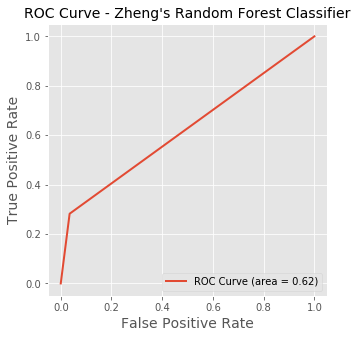

In [29]:
get_classification_result(y_pred, y_test, classifier_name="Zheng's Random Forest Classifier")

## Cross Validating Custom Classifier

In [0]:
# Grid of hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],    # Function for deciding tree separation
    'n_estimators': [150, 200, 250],     # Number of trees in forest
}

In [0]:
randomForestClfCustom = RandomForestClassifier(random_state=0)

In [0]:
rf_clf_CV = GridSearchCV(estimator=randomForestClfCustom, 
                         param_grid=param_grid, 
                         scoring={
                             'roc_auc_scorer': roc_auc_scorer,
                             'map_scorer': avg_precision_scorer, 
                         }, 
                         n_jobs=1, 
                         verbose=2, 
                         refit='roc_auc_scorer', 
                         cv=3)

In [25]:
rf_clf_cv_results = rf_clf_CV.fit(X=pipeline_custom.fit_transform(X_train), 
                                  y=y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] criterion=gini, n_estimators=150 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. criterion=gini, n_estimators=150, total= 4.4min
[CV] criterion=gini, n_estimators=150 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min remaining:    0.0s


[CV] ................. criterion=gini, n_estimators=150, total= 4.8min
[CV] criterion=gini, n_estimators=150 ................................
[CV] ................. criterion=gini, n_estimators=150, total= 4.6min
[CV] criterion=gini, n_estimators=200 ................................
[CV] ................. criterion=gini, n_estimators=200, total= 5.9min
[CV] criterion=gini, n_estimators=200 ................................
[CV] ................. criterion=gini, n_estimators=200, total= 6.1min
[CV] criterion=gini, n_estimators=200 ................................
[CV] ................. criterion=gini, n_estimators=200, total= 6.0min
[CV] criterion=gini, n_estimators=250 ................................
[CV] ................. criterion=gini, n_estimators=250, total= 7.5min
[CV] criterion=gini, n_estimators=250 ................................
[CV] ................. criterion=gini, n_estimators=250, total= 7.7min
[CV] criterion=gini, n_estimators=250 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 97.4min finished


In [0]:
# Saving the model with tuned hyperparameters
import pickle
pickle.dump(rf_clf_cv_results.best_estimator_, open('rf_clf_cv_best_estimator_.joblib', 'wb')) 

In [28]:
# Examining Random Forest Classifier Results
rf_clf_cv_results.best_params_

{'criterion': 'entropy', 'n_estimators': 250}

In [29]:
rf_clf_cv_results.best_score_

0.5144976951247991

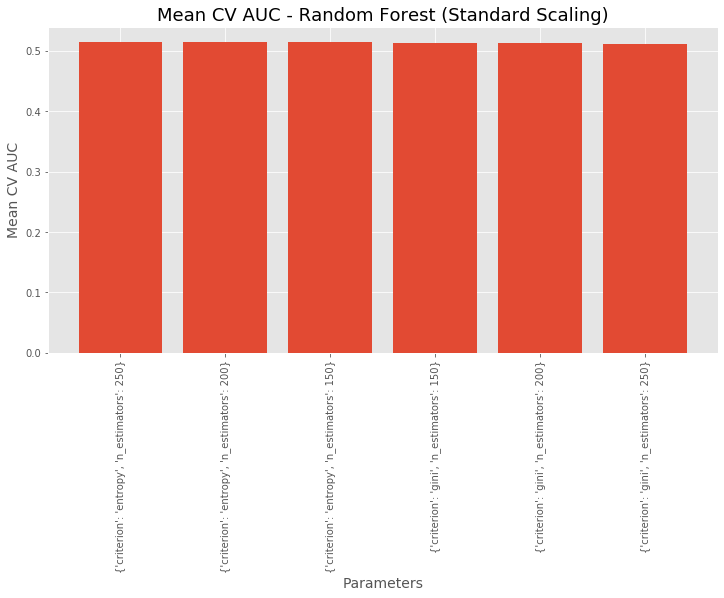

In [30]:
visualizeCVResults(rf_clf_cv_results, model_name='Random Forest (Standard Scaling)', 
                   metric='auc')